### Cancer prediction improved after removing correlated variables and selecting variables with high feature importances:
correlated variable identification: ProfileReport from pandas profiling, correlation coefficient and dendrogram

feature selection: permutation feature importance and Recursive feature elimination with cross validation


### Imports

In [1]:
#!pip install rfpimp

In [2]:
#!pip install category_encoders

In [3]:
#!pip install pandas_profiling

In [4]:
#!pip install mlxtend 

In [5]:
import category_encoders as ce
#from rfpimp import oob_importances, importances,plot_importances
from sklearn.feature_selection import RFECV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from mlxtend.evaluate import feature_importance_permutation as permu

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVC
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, f1_score,accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import pandas_profiling as pdprofile

%matplotlib inline


### Load data
downloaded from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [6]:
df = pd.read_csv('./data/BreastCancer.csv')
df.shape

(569, 33)

In [7]:
df.tail()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
564  926424         M        21.56         22.39          142.00     1479.0   
565  926682         M        20.13         28.25          131.20     1261.0   
566  926954         M        16.60         28.08          108.30      858.1   
567  927241         M        20.60         29.33          140.10     1265.0   
568   92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
564                  0.07115          NaN  
565                  0.06637          NaN  
566                  0.07820          NaN  
567                  0.12400          NaN  
568                  0.07039          NaN  

[5 rows x 33 columns]

### drop columns that are not useful

In [8]:
df.drop(['Unnamed: 32',"id"], axis=1, inplace=True)
df.describe(include='all')

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count        569   569.000000    569.000000      569.000000   569.000000   
unique         2          NaN           NaN             NaN          NaN   
top            B          NaN           NaN             NaN          NaN   
freq         357          NaN           NaN             NaN          NaN   
mean         NaN    14.127292     19.289649       91.969033   654.889104   
std          NaN     3.524049      4.301036       24.298981   351.914129   
min          NaN     6.981000      9.710000       43.790000   143.500000   
25%          NaN    11.700000     16.170000       75.170000   420.300000   
50%          NaN    13.370000     18.840000       86.240000   551.100000   
75%          NaN    15.780000     21.800000      104.100000   782.700000   
max          NaN    28.110000     39.280000      188.500000  2501.000000   

        smoothness_mean  compactness_mean  concavity_mean  \
count        569.000000        569.000000      569.000000   
unique              NaN               NaN             NaN   
top                 NaN               NaN             NaN   
freq                NaN               NaN             NaN   
mean           0.096360          0.104341        0.088799   
std            0.014064          0.052813        0.079720   
min            0.052630          0.019380        0.000000   
25%            0.086370          0.064920        0.029560   
50%            0.095870          0.092630        0.061540   
75%            0.105300          0.130400        0.130700   
max            0.163400          0.345400        0.426800   

        concave points_mean  symmetry_mean  ...  radius_worst  texture_worst  \
count            569.000000     569.000000  ...    569.000000     569.000000   
unique                  NaN            NaN  ...           NaN            NaN   
top                     NaN            NaN  ...           NaN            NaN   
freq                    NaN            NaN  ...           NaN            NaN   
mean               0.048919       0.181162  ...     16.269190      25.677223   
std                0.038803       0.027414  ...      4.833242       6.146258   
min                0.000000       0.106000  ...      7.930000      12.020000   
25%                0.020310       0.161900  ...     13.010000      21.080000   
50%                0.033500       0.179200  ...     14.970000      25.410000   
75%                0.074000       0.195700  ...     18.790000      29.720000   
max                0.201200       0.304000  ...     36.040000      49.540000   

        perimeter_worst   area_worst  smoothness_worst  compactness_worst  \
count        569.000000   569.000000        569.000000         569.000000   
unique              NaN          NaN               NaN                NaN   
top                 NaN          NaN               NaN                NaN   
freq                NaN          NaN               NaN                NaN   
mean         107.261213   880.583128          0.132369           0.254265   
std           33.602542   569.356993          0.022832           0.157336   
min           50.410000   185.200000          0.071170           0.027290   
25%           84.110000   515.300000          0.116600           0.147200   
50%           97.660000   686.500000          0.131300           0.211900   
75%          125.400000  1084.000000          0.146000           0.339100   
max          251.200000  4254.000000          0.222600           1.058000   

        concavity_worst  concave points_worst  symmetry_worst  \
count        569.000000            569.000000      569.000000   
unique              NaN                   NaN             NaN   
top                 NaN                   NaN             NaN   
freq                NaN                   NaN             NaN   
mean           0.272188              0.114606        0.290076   
std            0.208624              0.065732        0.061867   
min            0.000

In [9]:
#make a copy of unprocessed df for later comparison
unproce_df=df.copy()

### simple and fast exploratory data analysis of a Pandas Dataframe

In [10]:
pdprofile.ProfileReport(df)

### Another way to show coorelation using hierarchy.dendrogram to plot spearman correlation coefficiency

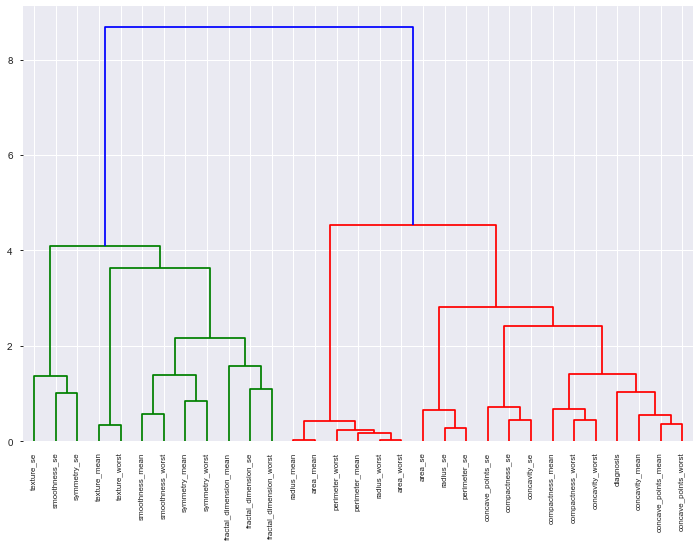

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
corr = spearmanr(df).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=df.columns, ax=ax,
                              leaf_rotation=90)
plt.show()

### A third way: using corr() to find Correlation Coefficiency

In [11]:
c = df.iloc[:,1:].corr().abs()
c

radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.323782        0.997855   0.987357   
texture_mean                0.323782      1.000000        0.329533   0.321086   
perimeter_mean              0.997855      0.329533        1.000000   0.986507   
area_mean                   0.987357      0.321086        0.986507   1.000000   
smoothness_mean             0.170581      0.023389        0.207278   0.177028   
compactness_mean            0.506124      0.236702        0.556936   0.498502   
concavity_mean              0.676764      0.302418        0.716136   0.685983   
concave_points_mean         0.822529      0.293464        0.850977   0.823269   
symmetry_mean               0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean      0.311631      0.076437        0.261477   0.283110   
radius_se                   0.679090      0.275869        0.691765   0.732562   
texture_se                  0.097317      0.386358        0.086761   0.066280   
perimeter_se                0.674172      0.281673        0.693135   0.726628   
area_se                     0.735864      0.259845        0.744983   0.800086   
smoothness_se               0.222600      0.006614        0.202694   0.166777   
compactness_se              0.206000      0.191975        0.250744   0.212583   
concavity_se                0.194204      0.143293        0.228082   0.207660   
concave_points_se           0.376169      0.163851        0.407217   0.372320   
symmetry_se                 0.104321      0.009127        0.081629   0.072497   
fractal_dimension_se        0.042641      0.054458        0.005523   0.019887   
radius_worst                0.969539      0.352573        0.969476   0.962746   
texture_worst               0.297008      0.912045        0.303038   0.287489   
perimeter_worst             0.965137      0.358040        0.970387   0.959120   
area_worst                  0.941082      0.343546        0.941550   0.959213   
smoothness_worst            0.119616      0.077503        0.150549   0.123523   
compactness_worst           0.413463      0.277830        0.455774   0.390410   
concavity_worst             0.526911      0.301025        0.563879   0.512606   
concave_points_worst        0.744214      0.295316        0.771241   0.722017   
symmetry_worst              0.163953      0.105008        0.189115   0.143570   
fractal_dimension_worst     0.007066      0.119205        0.051019   0.003738   

                         smoothness_mean  compactness_mean  concavity_mean  \
radius_mean                     0.170581          0.506124        0.676764   
texture_mean                    0.023389          0.236702        0.302418   
perimeter_mean                  0.207278          0.556936        0.716136   
area_mean                       0.177028          0.498502        0.685983   
smoothness_mean                 1.000000          0.659123        0.521984   
compactness_mean                0.659123          1.000000        0.883121   
concavity_mean                  0.521984          0.883121        1.000000   
concave_points_mean             0.553695          0.831135        0.921391   
symmetry_mean                   0.557775          0.602641        0.500667   
fractal_dimension_mean          0.584792          0.565369        0.336783   
radius_se                       0.301467          0.497473        0.631925   
texture_se                      0.068406          0.046205        0.076218   
perimeter_se                    0.296092          0.548905        0.660391   
area_se                         0.246552          0.455653        0.617427   
smoothness_se                   0.332375          0.135299        0.098564   
compactness_se                  0.318943          0.738722        0.670279   
concavity_se                    0.248396          0.570517        0.691270   
concave_points_se               0.380676          0.642262        0.683260   
symmetry_se                    

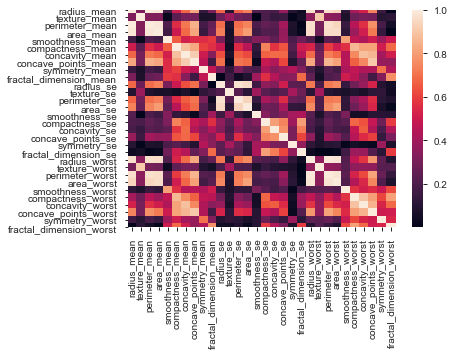

In [14]:
# plot the heatmap 
sns.heatmap(c, xticklabels=c.columns, yticklabels=c.columns)

### Values between 0.8 and 1.0 (-0.8 and -1.0) indicate a strong positive (negative) correlation.  Remove columns that have correlation coefficient >0.8

In [12]:
s = c.unstack()
s

radius_mean              radius_mean                1.000000
                         texture_mean               0.323782
                         perimeter_mean             0.997855
                         area_mean                  0.987357
                         smoothness_mean            0.170581
                                                      ...   
fractal_dimension_worst  compactness_worst          0.810455
                         concavity_worst            0.686511
                         concave_points_worst       0.511114
                         symmetry_worst             0.537848
                         fractal_dimension_worst    1.000000
Length: 900, dtype: float64

In [13]:
correlated=s[(s != 1) & (s>0.8)]
correlated=correlated.sort_values(ascending=False)
correlated.tail()

concavity_se          compactness_se          0.801268
compactness_worst     concave_points_worst    0.801080
concave_points_worst  compactness_worst       0.801080
area_mean             area_se                 0.800086
area_se               area_mean               0.800086
dtype: float64

In [14]:
# make a list of sets of the two index columns
sets=[set(correlated.index[i]) for i in range(len(correlated))]

In [15]:
# it's duplicated for each pair
sets[:10]

[{'perimeter_mean', 'radius_mean'},
 {'perimeter_mean', 'radius_mean'},
 {'perimeter_worst', 'radius_worst'},
 {'perimeter_worst', 'radius_worst'},
 {'area_mean', 'radius_mean'},
 {'area_mean', 'radius_mean'},
 {'area_mean', 'perimeter_mean'},
 {'area_mean', 'perimeter_mean'},
 {'area_worst', 'radius_worst'},
 {'area_worst', 'radius_worst'}]

In [16]:
## convert set to turple since set is unhashable
tuplepair=[tuple(sets[i]) for i in range(len(sets))]
tuplepair[:3]

[('perimeter_mean', 'radius_mean'),
 ('perimeter_mean', 'radius_mean'),
 ('radius_worst', 'perimeter_worst')]

In [17]:
# use set to remove the duplicates. To make set(x) work, x can't be list, set, dictionary ect. Needs to be immutable type
uniquepair=list(set(tuplepair))
# select only one of the pair
onevariable=[uniquepair[i][0] for i in range(len(uniquepair))]

In [18]:
len(onevariable)

48

In [19]:
# select the unique variables
uniquevariable=list(set(onevariable))
len(uniquevariable)

18

In [20]:
df.drop(uniquevariable, axis=1, inplace=True)

In [21]:
# confirm that no highly correlated columns now
c = df.iloc[:,1:].corr().abs()
c

texture_mean  smoothness_mean  symmetry_mean  \
texture_mean                1.000000         0.023389       0.071401   
smoothness_mean             0.023389         1.000000       0.557775   
symmetry_mean               0.071401         0.557775       1.000000   
fractal_dimension_mean      0.076437         0.584792       0.479921   
texture_se                  0.386358         0.068406       0.128053   
perimeter_se                0.281673         0.296092       0.313893   
smoothness_se               0.006614         0.332375       0.187321   
concavity_se                0.143293         0.248396       0.342627   
concave_points_se           0.163851         0.380676       0.393298   
symmetry_se                 0.009127         0.200774       0.449137   
perimeter_worst             0.358040         0.238853       0.219169   
symmetry_worst              0.105008         0.394309       0.699826   

                        fractal_dimension_mean  texture_se  perimeter_se  \
texture_mean                          0.076437    0.386358      0.281673   
smoothness_mean                       0.584792    0.068406      0.296092   
symmetry_mean                         0.479921    0.128053      0.313893   
fractal_dimension_mean                1.000000    0.164174      0.039830   
texture_se                            0.164174    1.000000      0.223171   
perimeter_se                          0.039830    0.223171      1.000000   
smoothness_se                         0.401964    0.397243      0.151075   
concavity_se                          0.446630    0.194998      0.362482   
concave_points_se                     0.341198    0.230283      0.556264   
symmetry_se                           0.345007    0.411621      0.266487   
perimeter_worst                       0.205151    0.102242      0.721031   
symmetry_worst                        0.334019    0.128215      0.109930   

                        smoothness_se  concavity_se  concave_points_se  \
texture_mean                 0.006614      0.143293           0.163851   
smoothness_mean              0.332375      0.248396           0.380676   
symmetry_mean                0.187321      0.342627           0.393298   
fractal_dimension_mean       0.401964      0.446630           0.341198   
texture_se                   0.397243      0.194998           0.230283   
perimeter_se                 0.151075      0.362482           0.556264   
smoothness_se                1.000000      0.268685           0.328429   
concavity_se                 0.268685      1.000000           0.771804   
concave_points_se            0.328429      0.771804           1.000000   
symmetry_se                  0.413506      0.309429           0.312780   
perimeter_worst              0.217304      0.226680           0.394999   
symmetry_worst               0.107342      0.197788           0.143116   

                        symmetry_se  perimeter_worst  symmetry_worst  
texture_mean               0.009127         0.358040        0.105008  
smoothness_mean            0.200774         0.238853        0.394309  
symmetry_mean              0.449137         0.219169        0.699826  
fractal_dimension_mean     0.345007         0.205151        0.334019  
texture_se                 0.411621         0.102242        0.128215  
perimeter_se               0.266487         0.721031        0.109930  
smoothness_se              0.413506         0.217304        0.107342  
concavity_se               0.309429         0.226680        0.197788  
concave_points_se          0.312780         0.394999        0.143116  
symmetry_se                1.000000         0.103753        0.389402  
perimeter_worst            0.103753         1.000000        0.269493  
symmetry_worst             0.389402         0.269493        1.000000

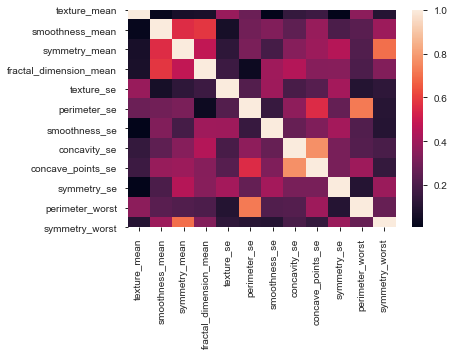

In [22]:
# plot the heatmap again
sns.heatmap(c, xticklabels=c.columns, yticklabels=c.columns)

### Code categorical data

In [23]:
for feature in df.select_dtypes(exclude=[np.number]).columns:
  print(f"Feature {feature}")
  print(df[feature].value_counts())
  print("\n\n")

Feature diagnosis
B    357
M    212
Name: diagnosis, dtype: int64





In [24]:
def diagnosis_to_num(diagnosis):
    return 1 if diagnosis=='M' else 0

categorical_encoder = ce.OrdinalEncoder(cols=['diagnosis'], return_df=True, mapping=[
     {'col': 'diagnosis', 'mapping': diagnosis_to_num}])


In [25]:
# check the conversion
df=categorical_encoder.fit_transform(df)
df.tail()

diagnosis  texture_mean  smoothness_mean  symmetry_mean  \
564          1         22.39          0.11100         0.1726   
565          1         28.25          0.09780         0.1752   
566          1         28.08          0.08455         0.1590   
567          1         29.33          0.11780         0.2397   
568          0         24.54          0.05263         0.1587   

     fractal_dimension_mean  texture_se  perimeter_se  smoothness_se  \
564                 0.05623       1.256         7.673       0.010300   
565                 0.05533       2.463         5.203       0.005769   
566                 0.05648       1.075         3.425       0.005903   
567                 0.07016       1.595         5.772       0.006522   
568                 0.05884       1.428         2.548       0.007189   

     concavity_se  concave_points_se  symmetry_se  perimeter_worst  \
564       0.05198            0.02454      0.01114           166.10   
565       0.03950            0.01678      0.01898           155.00   
566       0.04730            0.01557      0.01318           126.70   
567       0.07117            0.01664      0.02324           184.60   
568       0.00000            0.00000      0.02676            59.16   

     symmetry_worst  
564          0.2060  
565          0.2572  
566          0.2218  
567          0.4087  
568          0.2871

In [26]:
df.tail()

diagnosis  texture_mean  smoothness_mean  symmetry_mean  \
564          1         22.39          0.11100         0.1726   
565          1         28.25          0.09780         0.1752   
566          1         28.08          0.08455         0.1590   
567          1         29.33          0.11780         0.2397   
568          0         24.54          0.05263         0.1587   

     fractal_dimension_mean  texture_se  perimeter_se  smoothness_se  \
564                 0.05623       1.256         7.673       0.010300   
565                 0.05533       2.463         5.203       0.005769   
566                 0.05648       1.075         3.425       0.005903   
567                 0.07016       1.595         5.772       0.006522   
568                 0.05884       1.428         2.548       0.007189   

     concavity_se  concave_points_se  symmetry_se  perimeter_worst  \
564       0.05198            0.02454      0.01114           166.10   
565       0.03950            0.01678      0.01898           155.00   
566       0.04730            0.01557      0.01318           126.70   
567       0.07117            0.01664      0.02324           184.60   
568       0.00000            0.00000      0.02676            59.16   

     symmetry_worst  
564          0.2060  
565          0.2572  
566          0.2218  
567          0.4087  
568          0.2871

### Quick EDA with pairplot

In [27]:
# check if there is null value. pairplot will throw error with null
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [diagnosis, texture_mean, smoothness_mean, symmetry_mean, fractal_dimension_mean, texture_se, perimeter_se, smoothness_se, concavity_se, concave_points_se, symmetry_se, perimeter_worst, symmetry_worst]
Index: []

In [31]:
df.shape

(569, 13)

### Feature selection
Can be done with RandomForest. However the default feature_importances_ is misleading, and is particularly biased against unordered categorical variables (and biased toward continuous variables)
Permutation importance can be used https://explained.ai/rf-importance/index.html
    

In [32]:
y = df.diagnosis #target = diagnosis                 
X = df.drop(['diagnosis'],axis = 1 ) 

In [33]:
# split data train 75 % and test 25 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            class_weight='balanced',
                            min_samples_split=5,
                            oob_score=True)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

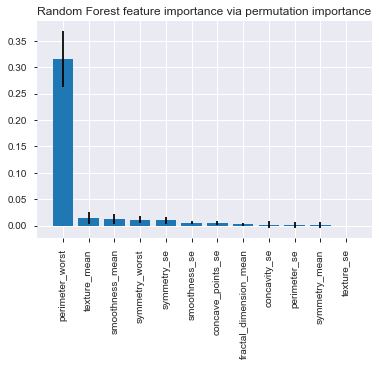

In [35]:
imp_vals, imp_all = permu(
    predict_method=rf.predict, 
    X=x_test.values[:,:],
    y=y_test.values,
    metric='accuracy',
    num_rounds=10,
    seed=1)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Random Forest feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Another method for comparison: Recursive feature elimination with cross validation
Not only find best features but also find how many features need for best accuracy.

In [38]:
x_train.shape

(426, 12)

In [45]:
# The "accuracy" scoring is proportional to the number of correct classifications
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            class_weight='balanced',
                            min_samples_split=10,
                            oob_score=True)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(5),scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'perimeter_se', 'smoothness_se',
       'concavity_se', 'concave_points_se', 'symmetry_se', 'perimeter_worst',
       'symmetry_worst'],
      dtype='object')


### The graph below showed 7 features gave 90% of the cross-validation score. Will only use these 7 features from permu + diagnosis

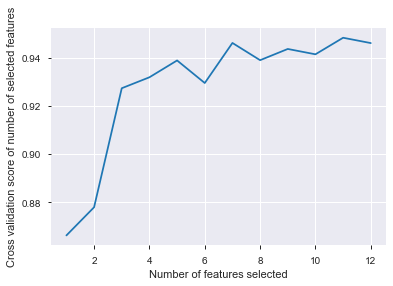

In [46]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [50]:
finaldf=df[['diagnosis','concave_points_se','symmetry_worst','texture_mean','symmetry_se', 'smoothness_se','perimeter_worst']]

In [51]:
finaldf.shape

(569, 7)

### Quick EDA

### check with pairplot
no highly correlated features, but some skewed features

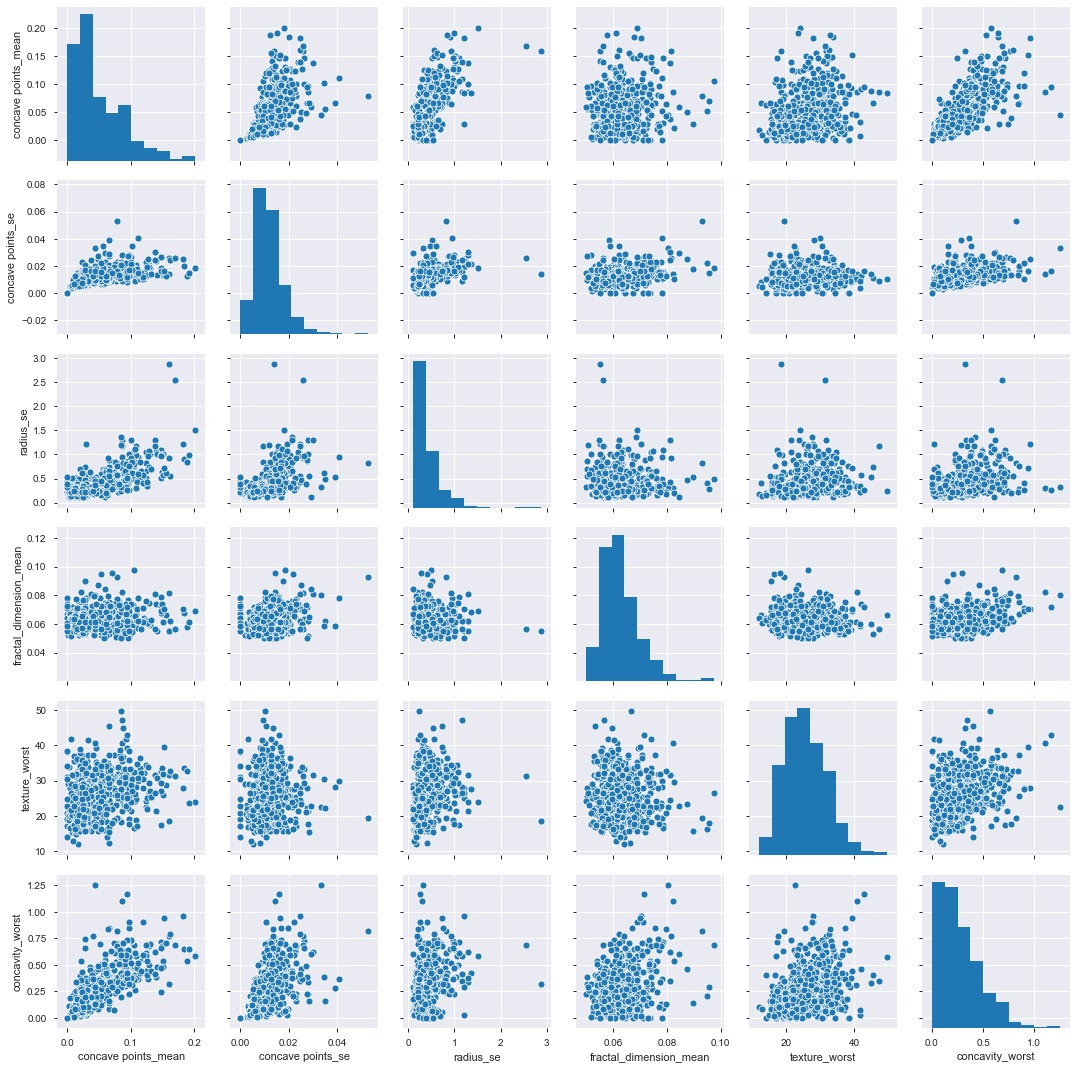

In [270]:
sns.pairplot(finaldf.iloc[:,1:])

In [52]:
finaldf.skew().sort_values()

diagnosis            0.528461
texture_mean         0.650450
perimeter_worst      1.128164
symmetry_worst       1.433928
concave_points_se    1.444678
symmetry_se          2.195133
smoothness_se        2.314450
dtype: float64

### log transfermation of the right-skewed features

In [53]:
# reset train test sets using 7-feature dataset
y = df.diagnosis #target = diagnosis                 
X = df.drop(['diagnosis'],axis = 1 ) 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
process_numeric = make_column_transformer(
    (FunctionTransformer(np.log1p, validate=False), ['smoothness_se','symmetry_se','concave_points_se','symmetry_worst','perimeter_worst']),
    (StandardScaler(), ['texture_mean']),
    remainder='passthrough'  # must have this, otherwise all the non-tranformed (i.e. categorical) features will be dropped!
)

In [55]:
preprocess_pipeline = Pipeline([
    ('transform_numeric', process_numeric)
])

In [57]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('SVC', SVC()) 
])
params = {'SVC__C':[6000,9000,12000],'SVC__gamma':['auto','scale'], 'SVC__kernel':['linear','rbf']}

grid = GridSearchCV(rf_pipeline, param_grid=params, cv=5, scoring='f1')
grid.fit(x_train, y_train)
grid.best_params_


{'SVC__C': 9000, 'SVC__gamma': 'auto', 'SVC__kernel': 'linear'}

In [58]:
prob_default_predicted = grid.decision_function(x_test)

In [59]:
roc_auc_score(y_test,prob_default_predicted)

0.9956304619225967

### Compare roc_auc_score before and after data processing. Data processing did improve the roc_auc_score

In [68]:

categorical_encoder = ce.OrdinalEncoder(cols=['diagnosis'], return_df=True, mapping=[
     {'col': 'diagnosis', 'mapping': diagnosis_to_num}])
unproce_df=categorical_encoder.fit_transform(unproce_df)

In [69]:
unproce_df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [70]:
y = unproce_df.diagnosis #target = diagnosis                 
X = unproce_df.drop(['diagnosis'],axis = 1 ) 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [75]:
clf=SVC(gamma='auto',C=9000,kernel='linear')

In [76]:
clf.fit(x_train,y_train)

SVC(C=9000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [77]:
predict_prob = clf.decision_function(x_test)

In [78]:
roc_auc_score(y_test,predict_prob)

0.9898044111527258

### The selected seven variables gave better predicting score than the original 30 variables:
- remove correlated variables 
- select high feature importances